<a href="https://colab.research.google.com/github/mgfrantz/CodingNomads-Intro-To-Deep-Learning/blob/master/Fundamentals/Our%20first%20neural%20network%20-%20linear%20regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
def seed_all(seed=42):
    """
    Sets the numpy and torch random seed.
    """
    np.random.seed(seed)
    torch.random.seed = seed

seed_all()

In [ ]:
# Create some X data
X = np.random.uniform(0, 10, 100)

In [ ]:
# Define the slope (m), bias (b), and some noise we want to add to X to make y
m = 3
b = 1.8
noise = np.random.normal(scale=3, size=100) # add this so we don't have a perfect line relationship

### Exercise 2.1: Create your `y` variable

In the cell above, we've created the slope `m`, the intercept `b`, and a noise factor `noise`. 
In the cell below, use multiplication and addition to create your `y` variable.

In [ ]:
# Your code here

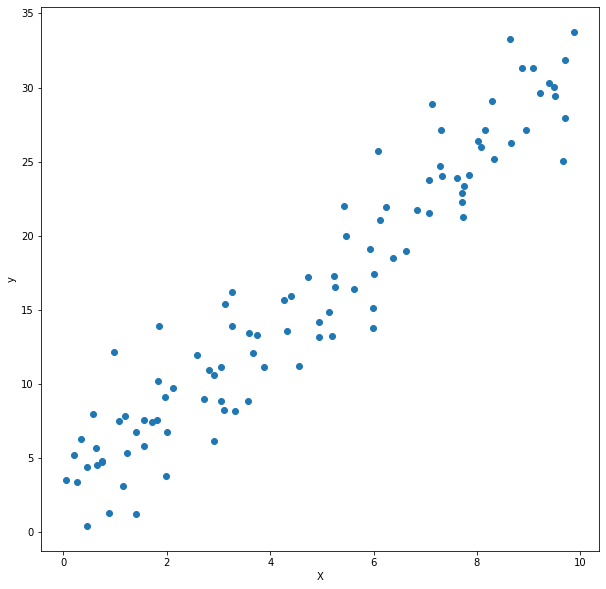

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.scatter(X, y)

### Let's define our loss function: mean squared error (MSE)

MSE is a great loss function for a regression task.

$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)^2
$$

Where
* $n$ is the number of items.
* $\sum_{i=1}^{n}$ means add things up, starting with the first item and ending with the $n$th item.
* $\hat{y_i}$ is the $i$th inference in an array of inferences/predictions.
* ${y_i}$ is the actual value that $\hat{y_i}$ was trying to predict.

Here's the logic behind MSE in python pseudocode:
```
ys = [y1, y2, ..., yn]
yhats = [yhat1, yhat2, ..., yhatn]

differences = []
for y, yhat in zip(ys, yhats):
    differences.append(y - yhat)

squared_differences = [i*i for i in differences]

mean_squared_error = np.mean(squared_differences)
```

We won't actually be using that logic because our predicted and actual values will all be in vectors.
So in reality, calculating it is much easier.
Below is the vectorized pseudocode:

```
ys = [y1, y2, ..., yn]
yhats = [yhat1, yhat2, ..., yhatn]

mse = ((ys - yhat)**2).mean()
```

In [ ]:
# Define MSE
def mse(predictions, actuals):
    return torch.square(predictions - actuals).mean()

In [ ]:
ys = torch.tensor([1,2,3])
yhats = torch.tensor([1.1, 2.1, 3.1])

In [ ]:
mse(ys, yhats)

tensor(0.0100)

In [ ]:
# Now that we've defined MSE, let's just use Torch's.
mse_loss = nn.MSELoss()
mse_loss(ys, yhats)

tensor(0.0100)

In [ ]:
# We can also use the functional API to calculate MSE
F.mse_loss(ys, yhats)

tensor(0.0100)

### Sanity check: linear regression in `scikit-learn`

We want to make sure that linear regression in `torch` is doing something we're familiar with.
Let's fit a quick linear model in `sklearn` to see if we can find a reasonable $m$ and $b$ here, so we can compare our parameters in torch.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# Fit a linear model on our data
lr = LinearRegression().fit(np.expand_dims(X, 1), y)

In [ ]:
# Display the slope and intercept
lr.coef_, lr.intercept_

(array([2.86206803]), 2.4452884726402466)

In [ ]:
# Calculate the mean squared error
mean_squared_error(y, lr.predict(X.reshape(-1, 1)))

7.259261075703482

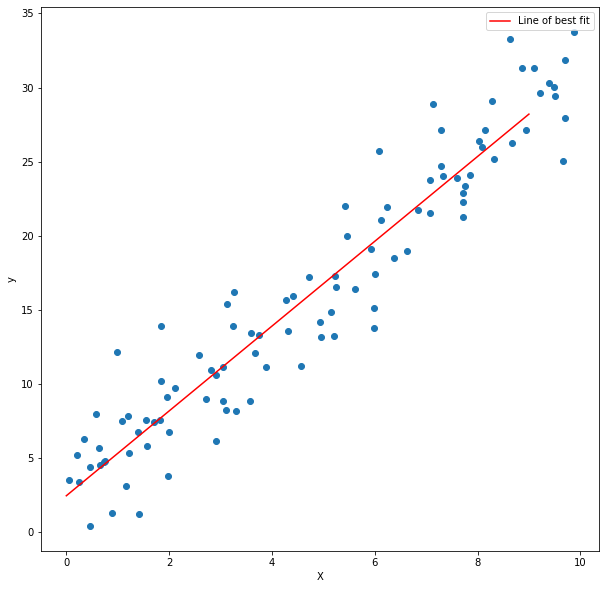

In [ ]:
# Plot our line of best fit
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.scatter(X, y)
_x = np.arange(0, 10)
_y = _x * lr.coef_[0] + lr.intercept_
ax.plot(_x, _y, c='red', label=f"Line of best fit")
ax.legend()

### Let's do the same thing in `torch`.

In [ ]:
# Because we're in torch now, let's just turn X and y into tensors.
X = torch.tensor(X)
y = torch.tensor(y)

Below, we initialize two `nn.Parameter`s, one for the slope and one for the bias.
**Parameters**, also referred to as **weights**, are values that we learn through gradient descent.
Right now, we only have two parameters that we'll learn in our linear model.

### Let's build a small network using `nn.Module`.

All layers and models in `torch` inherit somehow from the `nn.Module` class.
If you're not familiar with object-oriented programming (OOP), we suggest revisiting the python programming course. 
We'll use OOP regularly building models and when working with data.

When writing classes that inherit from `nn.Module`, there are only two things you really need to do. 
First, the class requires an `__init__` method.
This method should contain everything need to instantiate the class.
If you are building a layer from scratch, this can contain things like parameters. 
Below, we initialize two `nn.Parameter`s, one for the slope and one for the bias. 
**Parameters**, also sometimes referred to as **weights**, are values that we learn through **gradient descent** during the **training loop**.
For now, we are just initializing them as a random float between 0 and 1 using `torch.rand`, but we'll see later on in the course that how we initially populate our parameters with random numbers help deeper networks learn better.

Last, your class also requires a `forward` method, that takes in data and performs operations on that data using the operations defined in the `__init__`. 
Our `forward` method multiplies inputs `X` by the `slope`, then adds `bias`.
More generally, the `forward` method defines the order of operations to turn your input into predicted outputs.

In [ ]:
# Build our linear regression model
class LinReg(nn.Module):
    def __init__(self):
        super().__init__()
        # Randomly initialize 2 parameters, one for our slope and one for our bias.
        self.slope = nn.Parameter(torch.rand(1))
        self.bias = nn.Parameter(torch.rand(1))

    def forward(self, X):
        return X * self.slope + self.bias

### The Training Loop

We've now gotten to a place where we can train our model!
The training process consists of a few basic steps:

1. Make some predictions on your data using your model. This generally looks like `yhat = model(x)`.
1. Quantify how bad your parameters are using a loss function. The loss function will depend on the task you're performing (i.e. regression, classification). This generally looks like `loss = loss_function(y, yhat)`.
1. Calculate the gradient (slope) of the loss with respect to each parameter. This is calld backpropagation, and there is a separate lesson that goes into this in more detail. But for now, all it looks like is `loss.backward()`.
1. Update your weights using gradient descent. In this training loop we'll do it from scratch; in the future, we'll use an optimizer. There is a separate lesson on optimizers.
1. Repeat!

#### Gradient descent refresher

With gradient descent, our first step is to find the gradient of the loss with respect to our parameters.
We have some learning rate, generally small (`1e-3` is usually a good place to start). 
All we do is subtract the gradients times the learning rate from our parameters.
If the learning rate is too large, we will "bounce" out of minima in our loss function; if the learning rate is too small, it will take forever to find good parameters (to converge).
For a quick refresher on calculus and derivatives, check out [this post](https://forum.codingnomads.co/t/gradient-descent-got-you-down-math-help/1032/3) in the forums.
We will also be going into more detail in another lesson on how gradients are calculated.

In the code below, let's try training the model with a few different learning rates, from 1e-3 to 1e-1.
Play around with `LR` and re-run the next few cells to find a good learning rate.

In [ ]:
lr = LinReg()

In [ ]:
N_EPOCHS = 300
LR = 1e-3

In [ ]:
slopes = []
biases = []
losses = []
_alphas = []
for i in range(N_EPOCHS):
    # Make some inferences
    yhat = lr(X)
    # Measure how bad those guesses were
    loss = F.mse_loss(yhat, y)
    if i%(N_EPOCHS/10)==0:
        print(f"Epoch {i} Train Loss: {loss:.04f}")
    # Calculate the gradient of all the parameters with respect to the loss
    loss.backward()
    # Apply the SGD update rule
    lr.slope.data.sub_(lr.slope.grad * LR)
    lr.bias.data.sub_(lr.bias.grad * LR)
    # Zero out the gradients for the next round
    lr.slope.grad.zero_()
    lr.bias.grad.zero_()

    # Record the parameters and losses so we can plot them out later
    slopes.append(float(lr.slope.data.detach().numpy()))
    biases.append(float(lr.bias.data.detach().numpy()))
    losses.append(float(loss.detach().numpy()))
    _alphas.append(i/N_EPOCHS)

Epoch 0 Train Loss: 283.5407
Epoch 30 Train Loss: 13.7614
Epoch 60 Train Loss: 8.3545
Epoch 90 Train Loss: 8.2152
Epoch 120 Train Loss: 8.1818
Epoch 150 Train Loss: 8.1516
Epoch 180 Train Loss: 8.1224
Epoch 210 Train Loss: 8.0941
Epoch 240 Train Loss: 8.0668
Epoch 270 Train Loss: 8.0403


In [ ]:
lr.slope, lr.bias

(Parameter containing:
 tensor([3.1128], requires_grad=True), Parameter containing:
 tensor([0.8140], requires_grad=True))

Let's plot what we've done so far.
The blue dots represent the data, and the red lines represent the functions created by our slopes and biases as the model learns.
The more transparent lines are the first iterations in our training loop.
Notice that as the lines get more solid, they fit the data better.
This illustrates the process of our model learning the data!

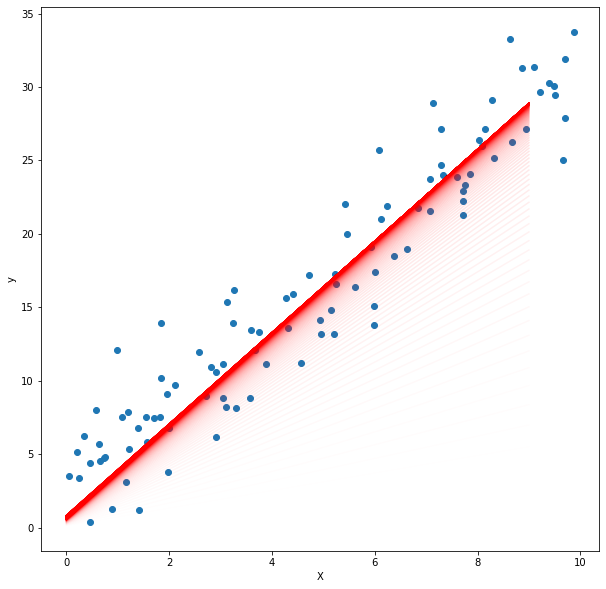

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.scatter(X, y)
for s, b, a in zip(slopes, biases, _alphas):
    _x = np.arange(0, 10)
    _y = _x * s + b
    ax.plot(_x, _y, alpha=a, c='red', label=f"Epoch {int(a)}")


Let's see what happens to the loss over our training.

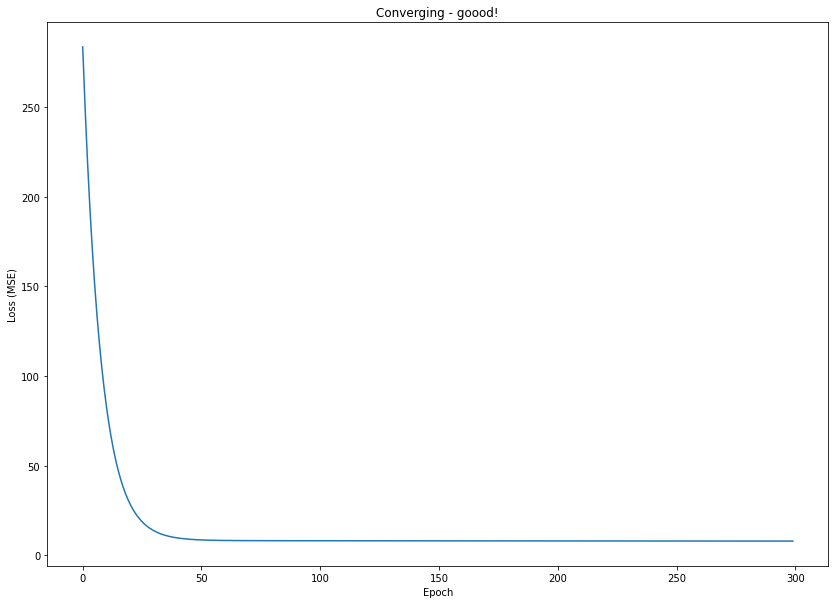

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
if (losses[-1] > losses[0]) | np.isnan(losses[-1]):
    ax.set_title('Diverging - BAD!')
else:
    ax.set_title('Converging - goood!')

<!-- split -->

## Multi-varable linear regression

Let's move from 1 parameter to many.
Below is a formula for a multi-variable linear regression

$$
\hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... \beta_nx_n
$$

Where
* $\hat{y}$ is an inference.
* $\beta_0$ (beta zero) represents the bias parameter.
* $\beta_1-\beta_n$ (beta 1 through beta $n$) represent the parameters we multiply our data by.
* $n$ represents the number of parameters.

Another way to represent this is with vectors.
We can defind a weights vector $w$ that comprises $\beta_1-\beta_n$.
This way, we can take the dot product of our data $x$ and our weights $w$, then just add $\beta_0$.
This is the approach we'll take in this next section.
Below, we write out how to calculate a prediction for one row of data.

$$
w = [\beta_1, \beta_2, ... , \beta_n]
$$

$$
x = [x_1, x_2, ... , x_n]
$$

$$
\hat{y}_i = w \cdot x + \beta_0
$$

In [ ]:
# Make yet another fake dataset
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=3, n_informative=2, bias=3, noise=2)

In [ ]:
# No more bad habits, we need to split our data.
X_train, X_valid, y_train, y_valid = (torch.tensor(i).float() for i in train_test_split(X, y, test_size=0.1, random_state=42))

In [ ]:
# Let's create some temporary weights and biases and test out our matrix operations before we build our model.
# Create a weights parameter with 1 beta per column in X
weights = nn.Parameter(torch.rand(X_train.shape[1]))
# Create our bias parameter
bias = nn.Parameter(torch.rand(1))

In [ ]:
# Test out the operation we want to perform in the forward pass
torch.matmul(X_train[:10], weights) + bias

tensor([0.3470, 0.1867, 0.6408, 0.6394, 0.5170, 0.2088, 0.9366, 0.6475, 1.1667,
        1.3188], grad_fn=<AddBackward0>)

In [ ]:
# FYI: @ does the same thing as matmul in this context and is easier
X_train[:10]@weights + bias

tensor([0.3470, 0.1867, 0.6408, 0.6394, 0.5170, 0.2088, 0.9366, 0.6475, 1.1667,
        1.3188], grad_fn=<AddBackward0>)

In [ ]:
# Sanity check: different implementations of our forward pass are the same
assert (X_train@weights + bias == torch.matmul(X_train, weights) + bias).all()

In [ ]:
# Let's make our model
class LinRegMulti(nn.Module):
    def __init__(self, n_cols):
        super().__init__()
        self.n_cols = n_cols

        self.weights = nn.Parameter(torch.rand(self.n_cols))
        self.bias = nn.Parameter(torch.rand(1))
    
    def forward(self, X):
        return X@self.weights.T + self.bias

In [ ]:
N_EPOCHS = 10000
LR = 1e-3

In [ ]:
lrm = LinRegMulti(X_train.shape[1])

In [ ]:
# Instead of updating each parameter individually, let's make an update rule function.
def gd_update_rule(parameters, lr):
    parameters.data.sub_(parameters.grad * lr)
    parameters.grad.zero_()

In [ ]:
train_losses = []
valid_losses = []

In [ ]:
for i in range(N_EPOCHS):
    yhat = lrm(X_train)
    loss = mse(yhat, y_train)
    loss.backward()
    for p in lrm.parameters():
        gd_update_rule(p, LR)
    train_losses.append(loss.detach().numpy())

    with torch.no_grad():
        yhat = lrm(X_valid)
        valid_loss = mse(yhat, y_valid)
        valid_losses.append(valid_loss.numpy())

    if i%(N_EPOCHS/10) == 0:
        print(f"Epoch {i} Train Loss: {loss:.04f}, Valid Loss: {valid_loss:.04f}")

Epoch 0 Train Loss: 2064.9336, Valid Loss: 2497.4429
Epoch 1000 Train Loss: 53.4068, Valid Loss: 64.8523
Epoch 2000 Train Loss: 5.3655, Valid Loss: 5.9552
Epoch 3000 Train Loss: 4.1692, Valid Loss: 4.2590
Epoch 4000 Train Loss: 4.1385, Valid Loss: 4.1793
Epoch 5000 Train Loss: 4.1377, Valid Loss: 4.1719
Epoch 6000 Train Loss: 4.1377, Valid Loss: 4.1711
Epoch 7000 Train Loss: 4.1377, Valid Loss: 4.1712
Epoch 8000 Train Loss: 4.1377, Valid Loss: 4.1712
Epoch 9000 Train Loss: 4.1377, Valid Loss: 4.1712


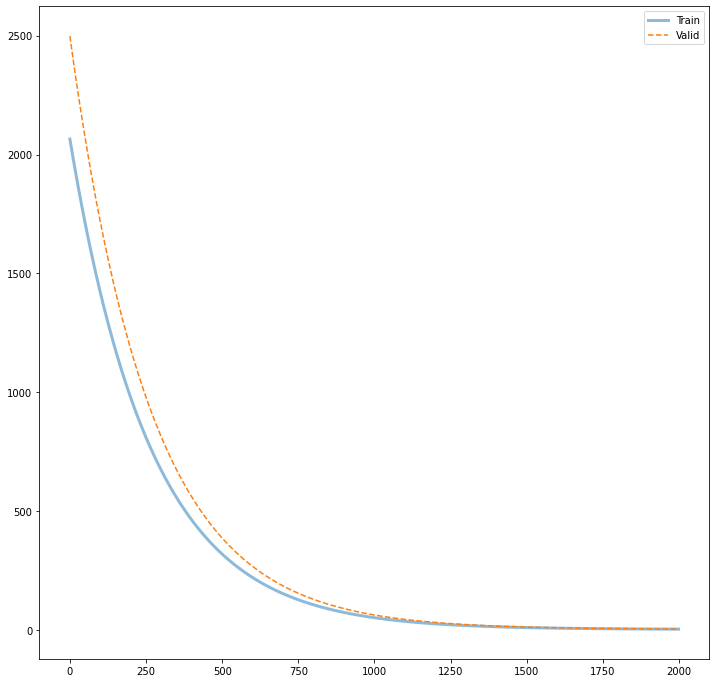

In [ ]:
EPOCHS_TO_SHOW = 2000
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(train_losses[:EPOCHS_TO_SHOW], label='Train', linewidth=3, alpha=0.5)
ax.plot(valid_losses[:EPOCHS_TO_SHOW], ls='--', label='Valid')
ax.legend()

In [ ]:
lrm.weights

Parameter containing:
tensor([2.7642e-02, 4.1119e+01, 2.4042e+01], requires_grad=True)

In [ ]:
lrm.bias

Parameter containing:
tensor([2.9828], requires_grad=True)

<!-- split -->

## Let's make it just a teeny bit "deep"

By the end of this section, you will have trained your first "deep" neural net.
The more layers you have, the deeper your net.
Since we're only fitting a simple function today, we'll move from 1 to 2 layers, but before too long we'll train nets with dozens of layers!

### The `Linear` layer

The `nn.Linear` layer is **super** important to understannd because it pops up everywhere.
Many more complex layers, such as `nn.LSTM` (as shown in the image below), are just composed of multiple `nn.Linear` layers.

![](https://miro.medium.com/max/1776/0*RTw6FuksHV6wPeII.jpeg)

`Linear` layers are sort of like linear regressions, except you can learn more than one linear function to fit the data.
A single `nn.Linear` layer with one output feature is the linear regression we did above.
But with greater than one output feature, we are projecting the data into a different space.
We can then stack additional layers on top of that to learn these more abstract features.
Adding nonlinearities between those layers will allow us to fit any continuous function.

In this section, we'll implement our own `Linear` layer, then use `nn.Linear`, and see that we get the same eventual result.
We'll end by stacking another `nn.Linear` layer and see that we learn the data in fewer passes than the single linear regression.


In [ ]:
class Linear(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.weights = nn.Parameter(torch.rand((dim_in, dim_out)))
        self.bias = nn.Parameter(torch.rand(dim_out))
    
    def forward(self, X):

        return X@self.weights + self.bias

In [ ]:
# Let's compare our Linear class with nn.Linear
l1 = Linear(3, 5)
l2 = nn.Linear(3, 5)

In [ ]:
l2.weight

Parameter containing:
tensor([[ 0.1261, -0.4116, -0.2836],
        [ 0.5469, -0.1500, -0.1198],
        [-0.2763,  0.2802,  0.2248],
        [ 0.0600,  0.2806,  0.5640],
        [-0.2803, -0.3451, -0.1081]], requires_grad=True)

In [ ]:
l1.weights

Parameter containing:
tensor([[0.3647, 0.5062, 0.8804, 0.1665, 0.3909],
        [0.1217, 0.2870, 0.6367, 0.7123, 0.7577],
        [0.0427, 0.6249, 0.2525, 0.5059, 0.4741]], requires_grad=True)

In [ ]:
# We need to make sure the weights have the same values.
# If they don't, we won't be able to compare the output.
# I'm not sure why the Linear layer's weights are transposed,
# but we'll see it doesn't matter.
l1.weights.data.copy_(l2.weight.T)
l1.bias.data.copy_(l2.bias)

tensor([-0.0488,  0.2582, -0.0391,  0.1375,  0.4323], grad_fn=<CopyBackwards>)

In [ ]:
l1(X_train[:5])

tensor([[ 0.0018, -0.3930,  0.1966,  0.1362,  1.0621],
        [-0.1389, -0.1051,  0.1354, -0.0803,  0.5544],
        [-0.3083,  0.1347,  0.1436,  0.2329,  0.2142],
        [ 0.0388,  0.4058, -0.1472,  0.0461,  0.3961],
        [ 0.5059,  0.4498, -0.4081, -0.1749,  0.9271]], grad_fn=<AddBackward0>)

In [ ]:
l2(X_train[:5])

tensor([[ 0.0018, -0.3930,  0.1966,  0.1362,  1.0621],
        [-0.1389, -0.1051,  0.1354, -0.0803,  0.5544],
        [-0.3083,  0.1347,  0.1436,  0.2329,  0.2142],
        [ 0.0388,  0.4058, -0.1472,  0.0461,  0.3961],
        [ 0.5059,  0.4498, -0.4081, -0.1749,  0.9271]],
       grad_fn=<AddmmBackward>)

In [ ]:
assert (l1(X_train[:5]) == l2(X_train[:5])).all()

Sometimes `torch`'s implementations with some optimizations that make operations run faster.
We'll see examples of this later in the course.
I was just curious to see whether `torch`'s implementation was significantly faster than ours using `%%timeit`.

In [ ]:
%%timeit 
l1(X_train[:5])

The slowest run took 13.03 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 16.6 µs per loop


In [ ]:
%%timeit
 l2(X_train[:5])

The slowest run took 14.16 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 15.6 µs per loop


### Nonlinearities (activation functions)

Up until this section, what we've done are a bunch of matrix multiplications.
Matrix multiplications can only perfomr [linear transformations](https://www.youtube.com/watch?v=kYB8IZa5AuE) of the data, like shearing, translation, rotation, reflection, and shearing.
Without some method of adding non-linearities, we will only be able to learn linear transformations of the original data, which doesn't help us learn nonlinear patterns.
**Activation functions** are nonlinearities you can add between layers that allow deep neural networks to learn any function.
While we'll use different activations at different points during this course, a good rule of thumb is just use a rectified linear unit (`F.relu`, `nn.ReLU`) between layers.

Why are addining nonlinearities important? 
[This youtube video](https://youtu.be/p50s63nPq9I?t=3069) from course.fast.ai gives some great intuition.
Basically, if we don't add any nonlinearities between layers, we're no better off than having just 1 linear layer.
If the weights matrices are big enough, we can approximate **any continuous function**!
We'll learnin more about why different activation functions help learnign when we discuss the vanishing and exploding gradient problems.

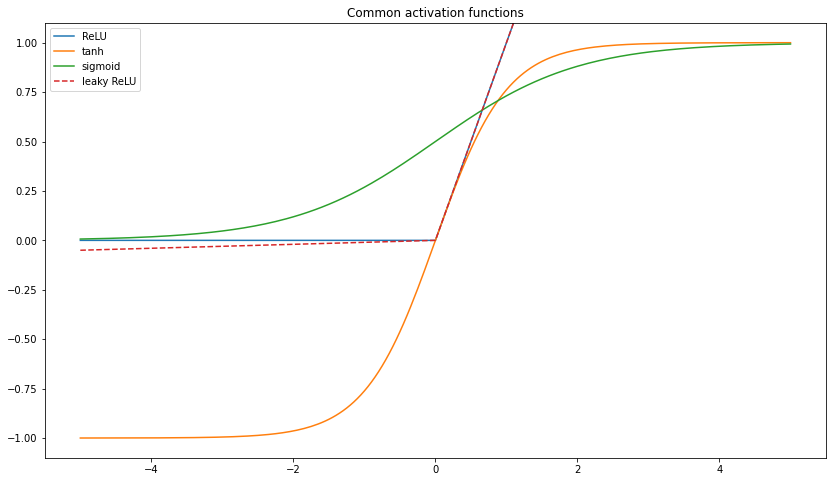

In [ ]:
rng = torch.arange(-5, 5.01, 0.05)
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(rng, F.relu(rng), label='ReLU')
ax.plot(rng, torch.tanh(rng), label='tanh')
ax.plot(rng, torch.sigmoid(rng), label='sigmoid')
ax.plot(rng, F.leaky_relu(rng, negative_slope=0.01), ls='--', label='leaky ReLU')
ax.set_ylim(-1.1, 1.1)
ax.set_title('Common activation functions')
ax.legend()

### Building a 2-layer fully-connected network

In [ ]:
class MultiLayerRegressor(nn.Module):
    def __init__(self, dim_in, hidden_dim):
        super().__init__()
        # self.first_layer = Linear(dim_in, hidden_dim)
        self.first_layer = nn.Linear(dim_in, hidden_dim)
        # self.second_layer = Linear(hidden_dim, 1)
        self.second_layer = nn.Linear(hidden_dim, 1)
    
    def forward(self, X):
        x = self.first_layer(X)
        # x = relu(x)
        x = F.relu(x)
        x = self.second_layer(x)
        return x

In [ ]:
def multilayer_regressor(in_dim, hidden_dim):
    return nn.Sequential(
        nn.Linear(in_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1)
    )

In [ ]:
# mlr = MultiLayerRegressor(3, 4)
mlr = multilayer_regressor(3, 4)

In [ ]:
train_losses = []
valid_losses = []

In [ ]:
LR = 1e-3
N_EPOCHS = 20000

In [ ]:
# Notice that instead of iterating through our parameters and applying
# an update rule, we're just using torch's built in SGD optimizer.
opt = optim.SGD(mlr.parameters(), lr=LR)

In [ ]:
for i in range(N_EPOCHS):
    yhat = mlr(X_train).squeeze()
    loss = F.mse_loss(yhat, y_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    train_losses.append(loss.detach().numpy())

    with torch.no_grad():
        yhat = mlr(X_valid).squeeze()
        valid_loss = F.mse_loss(yhat, y_valid)
        valid_losses.append(loss.numpy())
    
    if i%(N_EPOCHS/10) == 0:
        print(f"Epoch {i} Train loss: {loss:.04f}, Valid loss: {valid_loss:.04f}")

Epoch 0 Train loss: 2142.1021, Valid loss: 2601.9934
Epoch 2000 Train loss: 4.2766, Valid loss: 7.5538
Epoch 4000 Train loss: 4.1066, Valid loss: 6.0940
Epoch 6000 Train loss: 4.0994, Valid loss: 5.8847
Epoch 8000 Train loss: 4.0984, Valid loss: 5.8363
Epoch 10000 Train loss: 4.0981, Valid loss: 5.8453
Epoch 12000 Train loss: 4.0979, Valid loss: 5.8529
Epoch 14000 Train loss: 4.0978, Valid loss: 5.8591
Epoch 16000 Train loss: 4.0977, Valid loss: 5.8646
Epoch 18000 Train loss: 4.0976, Valid loss: 5.8686


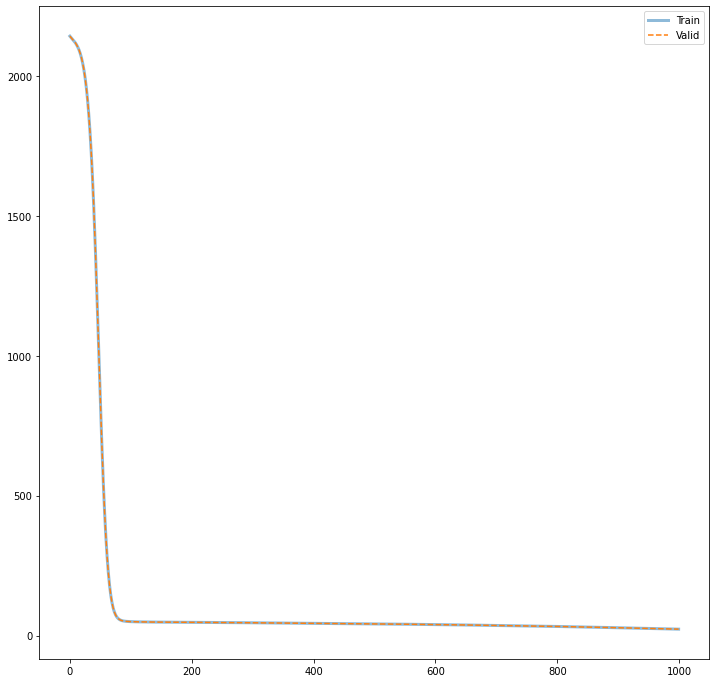

In [ ]:
idx=1000
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(train_losses[:idx], label='Train', linewidth=3, alpha=0.5)
ax.plot(valid_losses[:idx], ls='--', label='Valid')
ax.legend()

Notice that the multilayer regressor converged (i.e. found a loss minimum) between 80 and 100 epochs.
If you take a look above at our single-layer regressor, it took between 1000 and 2000 passes through the data to converge.
Adding additional layers and nonlinearities allowed us to learn the data in fewer passes.

[//]: # (split)

## Resources

* Try [this interactive tool](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.47853&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) to get a better idea of how hidden layers and nonlinearities can be used to fit complex functions. Notice that a with inputs $X_1$ and $X_2$ and 0 hidden layers, the network cannot fit the data. Adding just 1 hidden layer with 3 units and a nonlinear activation function fits the data.
* [Activation Functions section from course.fast.ai](https://youtu.be/p50s63nPq9I?t=3069)
* [3Blue1Brown: linear transformations](https://www.youtube.com/watch?v=kYB8IZa5AuE)